In [60]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import evalys
from evalys.jobset import JobSet

In [61]:
input_location = 'KTH-split/alloc-only'
num_parts = 16
schedule_names = ['backfill-1', 'backfill-sjf-1', 'maxutil-opt-10-1']
# schedule_names = ['backfill-1', 'backfill-sjf-1', 'maxutil-opt-10-1', 'window-10-10-1', 'plan-opt-square-0']

In [62]:
schedule_files = []
jobs_files = []
for file in os.listdir('../output/' + input_location):
    if file.endswith('_schedule.csv'):
        schedule_files.append(file)
    elif file.endswith('_jobs.csv'):
        jobs_files.append(file)

schedule_files = [os.path.join('../output', input_location, str(file)) for file in sorted(schedule_files)]
jobs_files = [os.path.join('../output', input_location, str(file)) for file in sorted(jobs_files)]

In [63]:
jobsets = {schedule: [None] * num_parts for schedule in schedule_names}
for file in jobs_files:
    schedule_name, part, _ = os.path.basename(file).split('_')
    part_index = int(part.split('-')[1])
    if schedule_name in schedule_names:
        jobsets[schedule_name][part_index] = JobSet.from_csv(file)

In [8]:
def transform_jobset_df(df):
    static_jobs = df[df.final_state == 'REJECTED'].set_index('jobID')
    dynamic_jobs = df[df.final_state != 'REJECTED']
    times = dynamic_jobs.groupby('workload_name').agg({'success': 'min', 'final_state': 'max', 'starting_time': 'min', 'finish_time':'max'}).reset_index()
    times['jobID'] = times.workload_name.apply(lambda s: s.split('%')[1])
    times.set_index('jobID', inplace=True)
    times.drop('workload_name', axis=1, inplace=True)
    static_jobs = static_jobs.loc[times.index].drop(['success', 'final_state', 'starting_time', 'finish_time'], axis=1).join(times)
    # If job timeout in the stage-in phase then allocated_resources and proc_alloc will be NaN
    resources = dynamic_jobs[dynamic_jobs.profile == 'parallel_homogeneous_profile_0'].groupby('workload_name').agg({'allocated_resources': 'first','proc_alloc': 'first'}).reset_index()
    resources['jobID'] = resources.workload_name.apply(lambda s: s.split('%')[1])
    resources.set_index('jobID', inplace=True)
    resources.drop('workload_name', axis=1, inplace=True)
    static_jobs = static_jobs.drop(['allocated_resources', 'proc_alloc'], axis=1).join(resources)
    static_jobs['execution_time'] = static_jobs.finish_time - static_jobs.starting_time
    static_jobs['waiting_time'] = static_jobs.starting_time - static_jobs.submission_time
    static_jobs['turnaround_time'] = static_jobs.finish_time - static_jobs.submission_time
    static_jobs['stretch'] = static_jobs.turnaround_time / static_jobs.execution_time
    static_jobs.reset_index(inplace=True)
    return static_jobs

In [14]:
def bounded_slowdown(df):
    return (df.turnaround_time / df.execution_time.clip(lower=600)).clip(lower=1)

def create_all_data_df():
    dfs = []
    for schedule in schedule_names:
        for i in range(len(jobsets[schedule])):
            df = jobsets[schedule][i].df
            df = df.assign(schedule=schedule, part=i, bounded_slowdown=bounded_slowdown(df))[['schedule', 'part', 'waiting_time', 'turnaround_time', 'stretch', 'bounded_slowdown']]
            df.rename({'stretch': 'slowdown'}, axis=1, inplace=True)
            dfs.append(df)
    return pd.concat(dfs, axis=0)

In [9]:
for schedule in schedule_names:
    for i in range(len(jobsets[schedule])):
        jobsets[schedule][i].df = transform_jobset_df(jobsets[schedule][i].df)

AttributeError: 'NoneType' object has no attribute 'df'

In [64]:
all_data = create_all_data_df()

In [65]:
aggregated = all_data.groupby(['schedule', 'part']).mean()
mean_data = aggregated.reset_index(level=[0,1])

<AxesSubplot:xlabel='schedule', ylabel='waiting_time'>

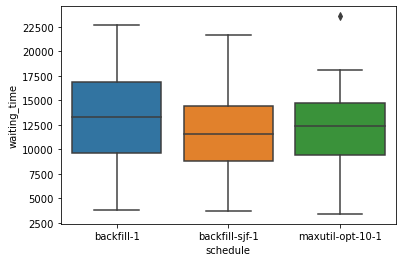

In [66]:
sns.boxplot(data=mean_data, x='schedule', y='waiting_time')

In [67]:
normalised = aggregated.copy()
for schedule in schedule_names:
    for i in range(num_parts):
        normalised.loc[schedule, i] = aggregated.loc[schedule, i] / aggregated.loc['backfill-sjf-1', i]
mean_normalised = normalised.reset_index(level=[0,1])

<AxesSubplot:xlabel='schedule', ylabel='waiting_time'>

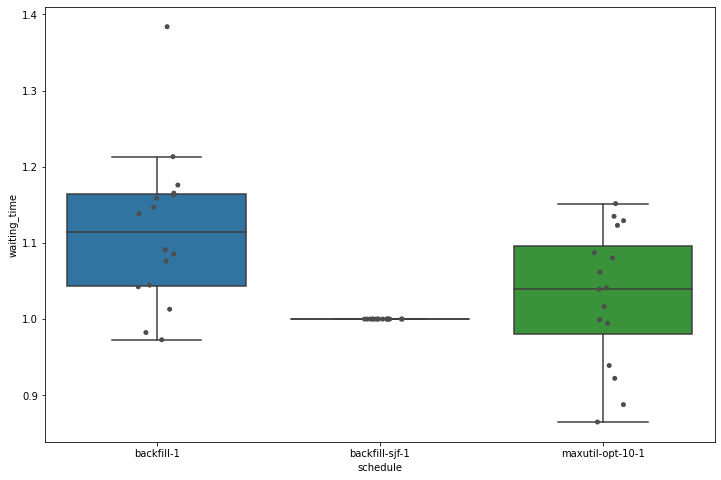

In [73]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(data=mean_normalised, x='schedule', y='waiting_time', fliersize=False)
sns.stripplot(data=mean_normalised, x='schedule', y='waiting_time', color=".3")

# sns.boxplot(data=mean_normalised, x='schedule', y='waiting_time', fliersize=False, color=".8")
# sns.swarmplot(data=mean_normalised, x='schedule', y='waiting_time')

# sns.violinplot(data=mean_normalised, x='schedule', y='waiting_time', fliersize=False)

# sns.violinplot(data=mean_normalised, x='schedule', y='waiting_time', inner=None, color=".8")
# sns.swarmplot(data=mean_normalised, x='schedule', y='waiting_time')
# sns.stripplot(data=mean_normalised, x='schedule', y='waiting_time')